In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.individual import Individual
from utils.draw import draw
import utils.protectedOperators as pOps

In [2]:
NUM_ISLANDS = 5
ISLAND_POPULATION = 100
GENERATIONS = 100
MAX_DEPTH = 6
MUTATION_RATE = 0.3
TOURNAMENT_SIZE = 3
MIGRATION_INTERVAL = 250
MIGRATION_SIZE = 2
PRINT_INTERVAL = 200
INDIVIDUAL_ATTEMPTS = 10
TEST_TRAIN = 0.8

In [3]:
def plot_fitness_trend(fitness_history):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, linestyle='-', color='blue', linewidth=2, label='Best Fitness')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

def plot_predictions(y_test, y_pred, fitness):
    sorted_idx = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sorted_idx]
    y_pred_sorted = np.array(y_pred)[sorted_idx]
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_sorted, label="Truth", color="red", linewidth=2)
    plt.plot(y_pred_sorted, label="Prediction", color="blue", linewidth=1)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Actual vs Predicted - Fitness: {fitness:.4f}")
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
class SymbolicRegression:
    def __init__(self, xTrain, yTrain,
                numIslands=NUM_ISLANDS,
                islandPopulation=ISLAND_POPULATION,
                generations=GENERATIONS,
                maxDepth=MAX_DEPTH,
                mutationRate=MUTATION_RATE,
                tournamentSize=TOURNAMENT_SIZE,
                migrationInterval=MIGRATION_INTERVAL,
                migrationSize=MIGRATION_SIZE,
                printInterval=PRINT_INTERVAL,
                individualAttempts=INDIVIDUAL_ATTEMPTS,
                ):
        self.xTrain = xTrain
        self.yTrain = yTrain
        self.numIslands = numIslands
        self.islandPopulation = islandPopulation
        self.generations = generations
        self.maxDepth = maxDepth
        self.mutationRate = mutationRate
        self.tournamentSize = tournamentSize
        self.migrationInterval = migrationInterval
        self.migrationSize = migrationSize
        self.printInterval = printInterval
        self.individualAttempts = individualAttempts
        self.populations = []

    def initializePopulation(self):
        self.populations = []
        for _ in range(self.numIslands):
            island = []
            while len(island) < self.islandPopulation:
                ind = Individual(self.maxDepth, self.xTrain, self.yTrain, self.individualAttempts)
                ind.generate()
                if np.isfinite(ind.fitness):
                    island.append(ind)
            self.populations.append(island)

    def tournamentSelection(self, population):
        tournamentSize = min(self.tournamentSize, len(population))
        participants = random.sample(population, tournamentSize)
        participants.sort(key=lambda ind: ind.fitness)
        weights = [tournamentSize - i for i in range(tournamentSize)]
        return random.choices(participants, weights=weights, k=1)[0]

    def migrate(self):
        for i in range(self.numIslands):
            source = self.populations[i]
            targetIndex = (i + 1) % self.numIslands
            target = self.populations[targetIndex]
            migrants = sorted(source, key=lambda ind: ind.fitness)[:self.migrationSize]
            targetSorted = sorted(target, key=lambda ind: ind.fitness, reverse=True)
            for j in range(self.migration_size):
                if migrants[j].fitness < targetSorted[j].fitness:
                    idx = target.index(targetSorted[j])
                    target[idx] = migrants[j].clone()
            self.populations[targetIndex] = target

    def evolve(self):
        self.initializePopulation()
        bestIndividual = None
        bestFitness = np.inf
        fitnessHistory = []
        for gen in tqdm(range(self.generations), desc="Generations"):
            for idx in range(self.numIslands):
                currentPop = self.populations[idx]
                newPop = []
                elite = min(currentPop, key=lambda ind: ind.fitness)
                newPop.append(elite.clone())
                while len(newPop) < self.islandPopulation:
                    if random.random() < self.mutationRate:
                        parent = self.tournamentSelection(currentPop)
                        child = parent.clone()
                        child.mutate()
                        newPop.append(child)
                    else:
                        parent1 = self.tournamentSelection(currentPop)
                        parent2 = self.tournamentSelection(currentPop)
                        child1, child2 = parent1.crossover(parent2)
                        newPop.extend([child1, child2])
                self.populations[idx] = sorted(currentPop + newPop, key=lambda ind: ind.fitness)[:self.islandPopulation]

            if (gen + 1) % self.migrationInterval == 0:
                self.migrate()

            for pop in self.populations:
                bestIsland = min(pop, key=lambda ind: ind.fitness)
                if bestIsland.fitness < bestFitness:
                    bestFitness = bestIsland.fitness
                    bestIndividual = bestIsland.clone()

            fitnessHistory.append(bestFitness)
            if (gen + 1) % self.printInterval == 0:
                print(f"Gen {gen+1} Best fitness: {bestFitness} Formula: {bestIndividual}")

        return bestIndividual, fitnessHistory


In [5]:
def runEvolve(
        dataSet,
        numIslands=NUM_ISLANDS,
        islandPopulation=ISLAND_POPULATION,
        generations=GENERATIONS,
        maxDepth=MAX_DEPTH,
        mutationRate=MUTATION_RATE,
        tournamentSize=TOURNAMENT_SIZE,
        migrationInterval=MIGRATION_INTERVAL,
        migrationSize=MIGRATION_SIZE,
        printInterval=PRINT_INTERVAL,
        individualAttempts=INDIVIDUAL_ATTEMPTS,
        testTrain=TEST_TRAIN
    ):
    problem = np.load(f'./data/problem_{dataSet}.npz')
    xData, yData = problem['x'], problem['y']
    perm = np.random.permutation(len(yData))
    xData = xData[:, perm]
    yData = yData[perm]

    trainPopulation = int(TEST_TRAIN * len(yData))
    xTrain, yTrain = xData[:, :trainPopulation], yData[:trainPopulation]
    xTest, yTest = xData[:, trainPopulation:], yData[trainPopulation:]

    symReg = SymbolicRegression(xTrain, yTrain,
        numIslands
    )
    print(f"\nProblem {dataSet}")
    bestIndividual, history = symReg.evolve()

    testIndividual = bestIndividual.clone()
    testIndividual.xTrain = xTest
    testIndividual.yTrain = yTest
    y_pred = testIndividual.computeFitness(get_pred=True)

    print("Best Formula:", bestIndividual)
    print("Train fitness:", bestIndividual.fitness)
    print("Test fitness:", bestIndividual.fitness)

    #draw(bestIndividual.root)  # visual graph
    plot_fitness_trend(history)
    plot_predictions(yTest, y_pred, testIndividual.fitness)


Problem 1


Generations: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Best Formula: x0
Train fitness: 0.003419513318827051
Test fitness: 0.003419513318827051


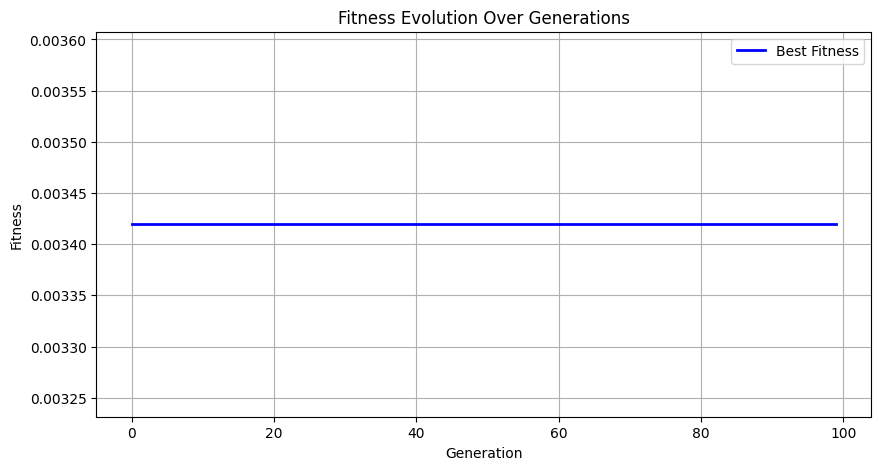

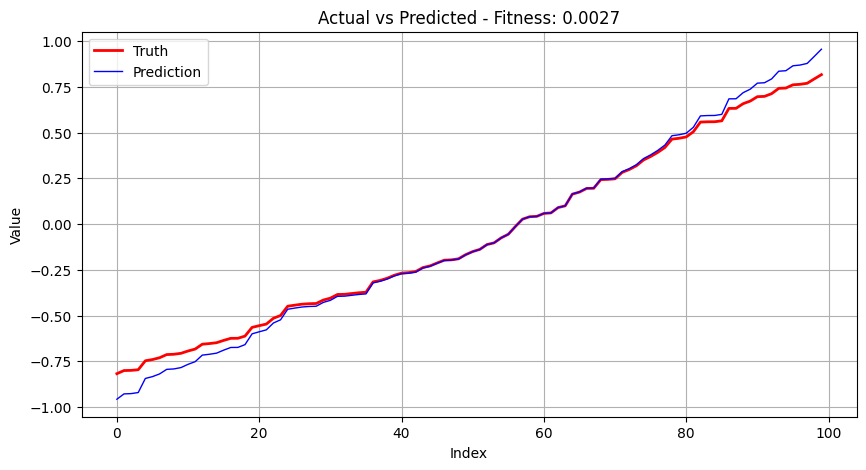

In [6]:

np.seterr(all='ignore')
runEvolve(
    dataSet=1,
    numIslands=NUM_ISLANDS,
    islandPopulation=ISLAND_POPULATION,
    generations=GENERATIONS,
    maxDepth=MAX_DEPTH,
    mutationRate=MUTATION_RATE,
    tournamentSize=TOURNAMENT_SIZE,
    migrationInterval=MIGRATION_INTERVAL,
    migrationSize=MIGRATION_SIZE,
    printInterval=PRINT_INTERVAL,
    individualAttempts=INDIVIDUAL_ATTEMPTS,
    testTrain=TEST_TRAIN
)